# 1. 导入相关库

In [104]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 2. 设计数据类

dataset = Dataset(normClosePrice,lookback)      
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True)   

for i, (x,y) in enumerate(dataloader):    

In [105]:
class Dataset(Dataset):
    
    def __init__(self, stock, lookback=20, flag="train"):
        data_raw = stock.to_numpy() 
        data = []

        # you can free play（seq_length）
        for index in range(len(data_raw) - lookback): 
            data.append(data_raw[index: index + lookback])

        data = np.array(data)
        test_set_size = int(np.round(0.2 * data.shape[0]))
        train_set_size = data.shape[0] - (test_set_size)
        
        if flag == "train":
            self.x = data[:train_set_size,:-1,:]
            self.y = data[:train_set_size,-1,0:1]
            self.n_samples = len(self.x)
        else:
            self.x = data[train_set_size:,:-1,:]
            self.y = data[train_set_size:,-1,0:1]
            self.n_samples = len(self.x)
            
    
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    
    def __len__(self):
        return self.n_samples

# 3. 自定义模型

In [106]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size, 24)
        self.bn1 = nn.BatchNorm1d(24)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(24,48)
        self.bn2 = nn.BatchNorm1d(48)
        self.l3 = nn.Linear(48,36)
        self.bn3 = nn.BatchNorm1d(36)
        self.l4 = nn.Linear(36,8)
        self.bn4 = nn.BatchNorm1d(8)
        self.l5 = nn.Linear(8,output_size)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        return out


# 4. 训练过程

In [107]:
data = pd.read_csv('data/rlData.csv', index_col=0)
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


特征工程

In [108]:
closePrice = data[['Close']]
scaler = MinMaxScaler((-1,1)) 
scaler.fit(closePrice)
normClosePrice = scaler.transform(closePrice)
normClosePrice = pd.DataFrame(normClosePrice)
normClosePrice.head()

,0
0,-0.774584
1,-0.819985
2,-0.820745
3,-0.679082
4,-0.623868


In [109]:
# 超参数
num_epochs = 50
batch_size = 64
learning_rate = 0.0005
lookback = 20
output_size = 1


# Load data
dataset = Dataset(normClosePrice,lookback)
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, 
                        shuffle=True)

input_size = lookback - 1
model = NeuralNet(input_size, output_size)
# loss
criterion = nn.MSELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(dataloader)
for epoch in range(num_epochs):
    model.train()

    for i, (x,y) in enumerate(dataloader):
        x = x.reshape(x.shape[0], -1).float()
        y = y.float()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        if (epoch+1) % 10 ==0: 
            if (i+1) % 1 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.5f}')

Epoch [10/50], Step [1/3], Loss: 0.30589
Epoch [10/50], Step [2/3], Loss: 0.28055
Epoch [10/50], Step [3/3], Loss: 0.21083
Epoch [20/50], Step [1/3], Loss: 0.19033
Epoch [20/50], Step [2/3], Loss: 0.24011
Epoch [20/50], Step [3/3], Loss: 0.23441
Epoch [30/50], Step [1/3], Loss: 0.12424
Epoch [30/50], Step [2/3], Loss: 0.14898
Epoch [30/50], Step [3/3], Loss: 0.10656
Epoch [40/50], Step [1/3], Loss: 0.03384
Epoch [40/50], Step [2/3], Loss: 0.02580
Epoch [40/50], Step [3/3], Loss: 0.01689
Epoch [50/50], Step [1/3], Loss: 0.00849
Epoch [50/50], Step [2/3], Loss: 0.00303
Epoch [50/50], Step [3/3], Loss: 0.00768


模型保存

In [110]:
FILE = f'./model_ANN.pth'
torch.save(model, FILE)

# 5. Inference

In [111]:
dataset = Dataset(normClosePrice,lookback, "test")
input_x = dataset.x
input_x =input_x.reshape(-1, 19)
y_test_pred = model(torch.tensor(input_x).float())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())

In [112]:
y_test = dataset.y
y_test = scaler.inverse_transform(y_test)
y_test.shape

(46, 1)

Text(0.5, 1.0, 'Model ANN')

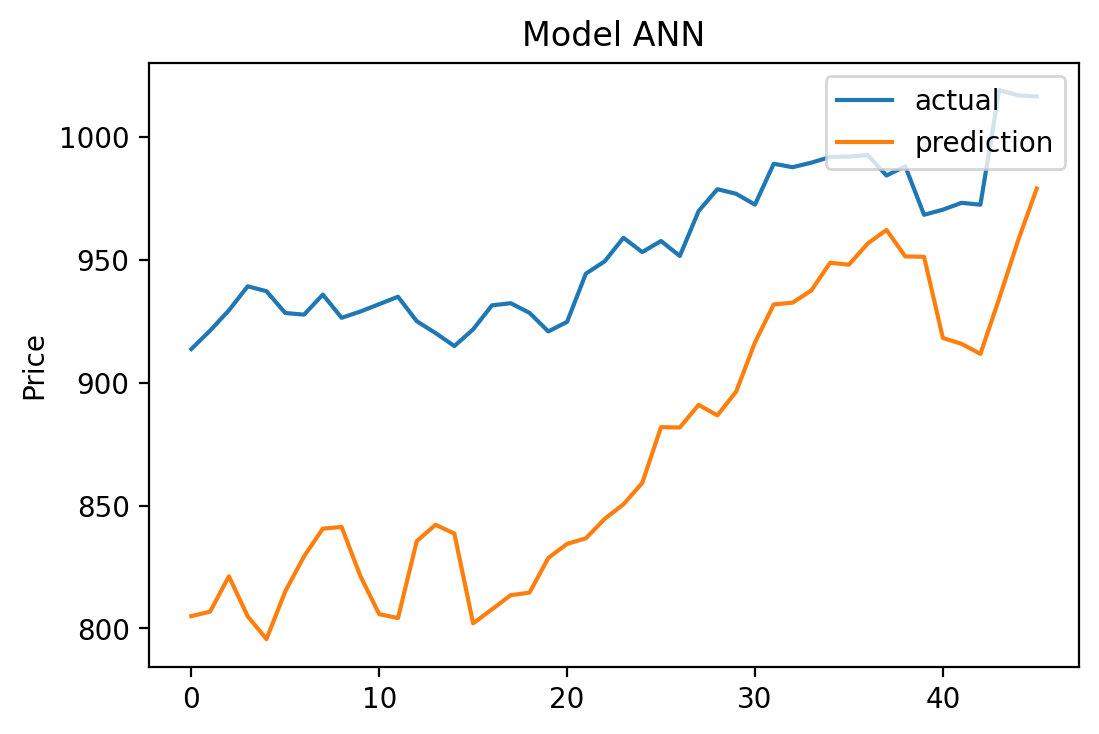

In [113]:
# Visualize
fig = plt.figure(figsize=(6,4), dpi=200)
plt.plot(y_test, label = 'actual')
plt.plot(y_test_pred, label = 'prediction')

plt.legend(loc=1)
plt.ylabel('Price')
plt.title('Model ANN')